The goal of this notebook is to understand how much data per home and per period should be considered as necessary to include the home in the computation of the energy estimate. The function to load the cached data (load_cached_data() in utils.py) has the option 'full', which, when set to False, will remove homes with the amount of missing data above a threshold. This threshold is set in the config file and this notebook should help in finding a good value.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '../src')

import pickle
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.ticker as plticker

from datetime import timedelta
from pathlib import Path
from multiprocessing import Pool
from functools import partial

from IdealDataInterface import IdealDataInterface

from config import CACHE_FOLDER, EVALUATION_PERIOD

from utils import treatment_control, load_cached_data

In [3]:
# Run plotting styles
%run -i '../src/sns_styles.py'

cmap = sns.color_palette()

In [4]:
df_group = treatment_control()

df_group.head()

,homeid,group,start_date,end_date
0,47,treatment,2017-03-16,2017-05-08
1,59,control,2017-03-16,2018-01-28
2,61,enhanced,2017-02-14,2017-10-19
3,62,enhanced,2017-02-14,2018-06-30
4,64,treatment,2017-03-16,2018-06-30


In [5]:
treatment_homes = df_group.loc[df_group['group'] == 'treatment', 'homeid']
control_homes = df_group.loc[df_group['group'] == 'control', 'homeid']

print('Found {} treatment and {} control homes.'.format(len(treatment_homes), len(control_homes)))

Found 107 treatment and 107 control homes.


## P1_1

Plot a histogram of the available data ratio (from 0 to 1, 0 being all data is missing and 1 all data points are available). The y-axis is the number of homes, the x-axis is the available data-ratio. For the IDEAL data, I thought that a threshold of 0.7 probably is a good value to exclude homes with too bad data. Treatment homes will be shown in blue, control homes will be shown in orange.

In [6]:
period = 'P1_1'

df = load_cached_data(period, full=True)

In [7]:
print('Number of homes with all missing data: {}'.format(df.isna().all(axis=0).sum()))

Number of homes with all missing data: 0


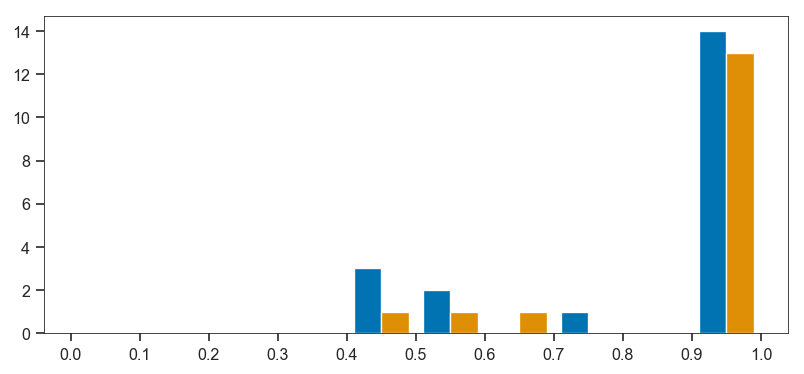

In [8]:
# Compute the mean of available data rate
idx_drate_treatment = df.loc[:,df.columns.isin(treatment_homes)].notna().mean(axis=0)
idx_drate_control = df.loc[:,df.columns.isin(control_homes)].notna().mean(axis=0)

plt.hist([idx_drate_treatment, idx_drate_control], bins=np.arange(0,1.1,0.1));

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

Look at the actual plots of the electricity readings for the cases that fall below the threshold to see if it makes sense to exclude them. In the present case, it can be seen that there are many larger gaps. For later periods (periods during times of high load for the IDEAL server), it can be seen that not only large gaps, but also low propagation rate seems to be a problem.

/disk/scratch/nberline/bin/miniconda3/envs/impact/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


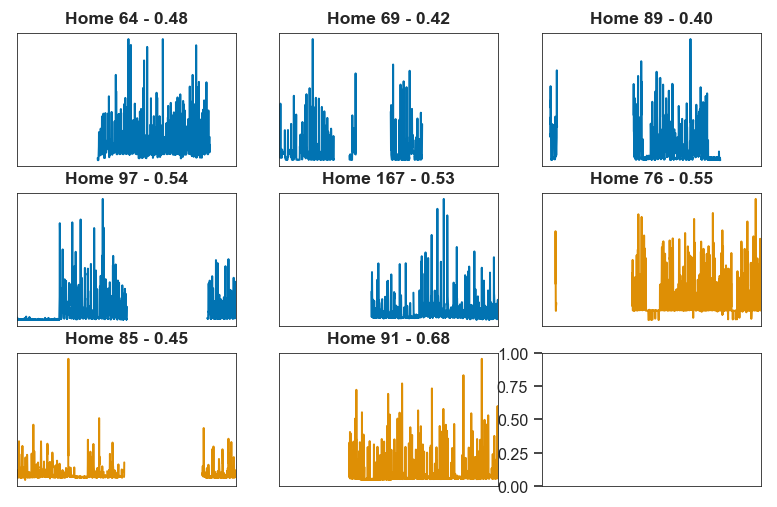

In [9]:
threshold = 0.7

idx_tmp = list(idx_drate_treatment[idx_drate_treatment < threshold].index) + \
          list(idx_drate_control[idx_drate_control < threshold].index)

df_tmp = df.loc[:,idx_tmp].resample('1h').mean()

# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(size_x, size_y), sharex=True)

i, j = 0, 0
for k in range(df_tmp.shape[1]):
    # Plot the data
    color = cmap[0]
    if k >= sum(idx_drate_treatment < threshold):
        color = cmap[1]
        
    axes[i,j].plot(df_tmp.iloc[:,k], color=color)
    
    axes[i,j].set_title('Home {} - {:.2f}'.format(df_tmp.columns[k], df.loc[:,idx_tmp[k]].notna().mean()))
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    
    axes[i,j].set_xlim((df.index.min(), df.index.max()))
    
    # Advance the subplot
    j += 1
    if j >= 3:
        i += 1
        j = 0

## P1_2

In [10]:
period = 'P1_2'

df = load_cached_data(period, full=True)

In [11]:
print('Number of homes with all missing data: {}'.format(df.isna().all(axis=0).sum()))

Number of homes with all missing data: 0


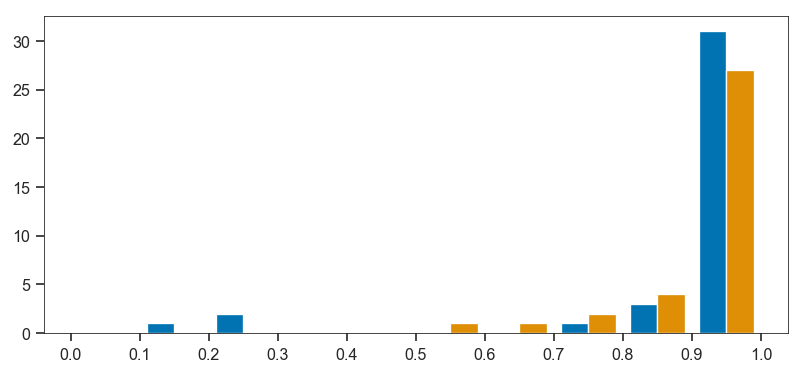

In [12]:
# Compute the mean of available data rate
idx_drate_treatment = df.loc[:,df.columns.isin(treatment_homes)].notna().mean(axis=0)
idx_drate_control = df.loc[:,df.columns.isin(control_homes)].notna().mean(axis=0)

plt.hist([idx_drate_treatment, idx_drate_control], bins=np.arange(0,1.1,0.1));

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

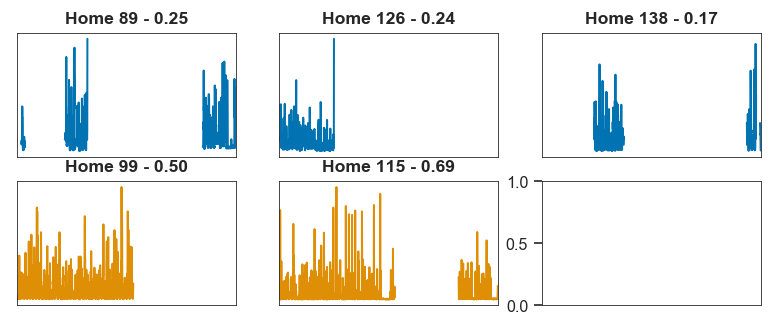

In [13]:
threshold = 0.7

idx_tmp = list(idx_drate_treatment[idx_drate_treatment < threshold].index) + \
          list(idx_drate_control[idx_drate_control < threshold].index)

df_tmp = df.loc[:,idx_tmp].resample('1h').mean()

# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(size_x, size_y), sharex=True)

i, j = 0, 0
for k in range(df_tmp.shape[1]):
    # Plot the data
    color = cmap[0]
    if k >= sum(idx_drate_treatment < threshold):
        color = cmap[1]
        
    axes[i,j].plot(df_tmp.iloc[:,k], color=color)
    
    axes[i,j].set_title('Home {} - {:.2f}'.format(df_tmp.columns[k], df.loc[:,idx_tmp[k]].notna().mean()))
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    
    axes[i,j].set_xlim((df.index.min(), df.index.max()))
    
    # Advance the subplot
    j += 1
    if j >= 3:
        i += 1
        j = 0

## P2_1

In [14]:
period = 'P2_1'

df = load_cached_data(period, full=True)

In [15]:
print('Number of homes with all missing data: {}'.format(df.isna().all(axis=0).sum()))

Number of homes with all missing data: 0


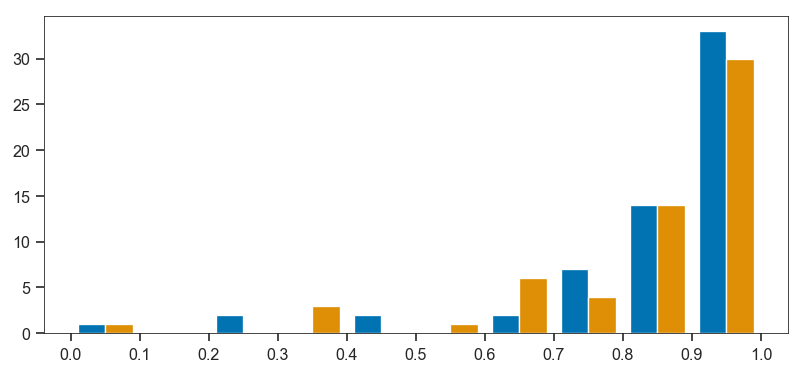

In [16]:
# Compute the mean of available data rate
idx_drate_treatment = df.loc[:,df.columns.isin(treatment_homes)].notna().mean(axis=0)
idx_drate_control = df.loc[:,df.columns.isin(control_homes)].notna().mean(axis=0)

plt.hist([idx_drate_treatment, idx_drate_control], bins=np.arange(0,1.1,0.1));

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

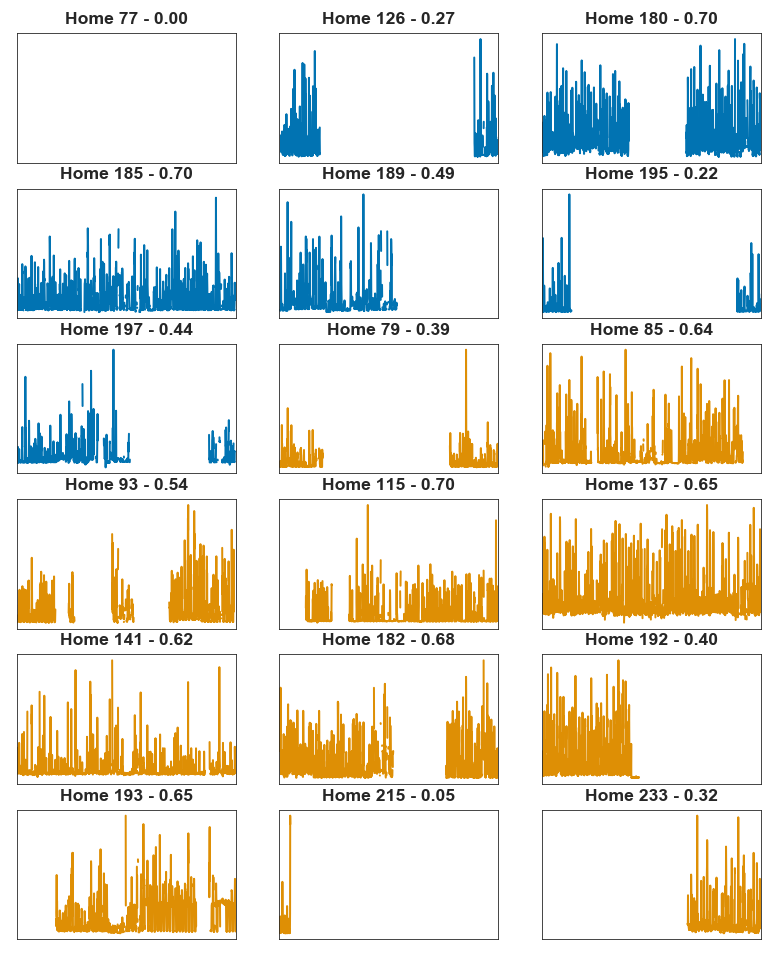

In [17]:
threshold = 0.7

idx_tmp = list(idx_drate_treatment[idx_drate_treatment < threshold].index) + \
          list(idx_drate_control[idx_drate_control < threshold].index)

df_tmp = df.loc[:,idx_tmp].resample('1h').mean()

# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(size_x, size_y), sharex=True)

i, j = 0, 0
for k in range(df_tmp.shape[1]):
    # Plot the data
    color = cmap[0]
    if k >= sum(idx_drate_treatment < threshold):
        color = cmap[1]
        
    axes[i,j].plot(df_tmp.iloc[:,k], color=color)
    
    axes[i,j].set_title('Home {} - {:.2f}'.format(df_tmp.columns[k], df.loc[:,idx_tmp[k]].notna().mean()))
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    
    axes[i,j].set_xlim((df.index.min(), df.index.max()))
    
    # Advance the subplot
    j += 1
    if j >= 3:
        i += 1
        j = 0

## P2_2

In [18]:
period = 'P2_2'

df = load_cached_data(period, full=True)

In [19]:
print('Number of homes with all missing data: {}'.format(df.isna().all(axis=0).sum()))

Number of homes with all missing data: 1


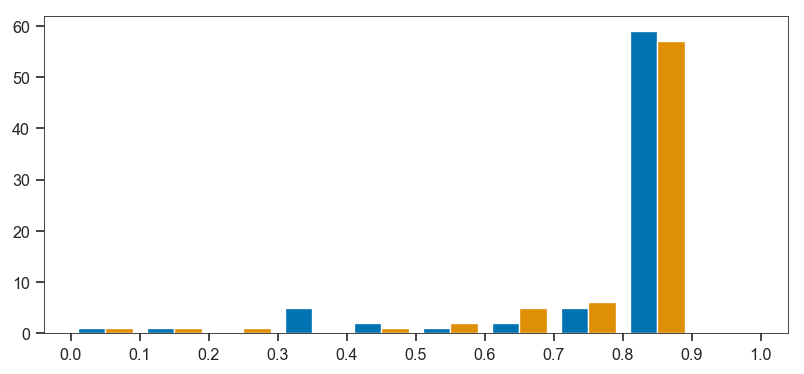

In [20]:
# Compute the mean of available data rate
idx_drate_treatment = df.loc[:,df.columns.isin(treatment_homes)].notna().mean(axis=0)
idx_drate_control = df.loc[:,df.columns.isin(control_homes)].notna().mean(axis=0)

plt.hist([idx_drate_treatment, idx_drate_control], bins=np.arange(0,1.1,0.1));

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

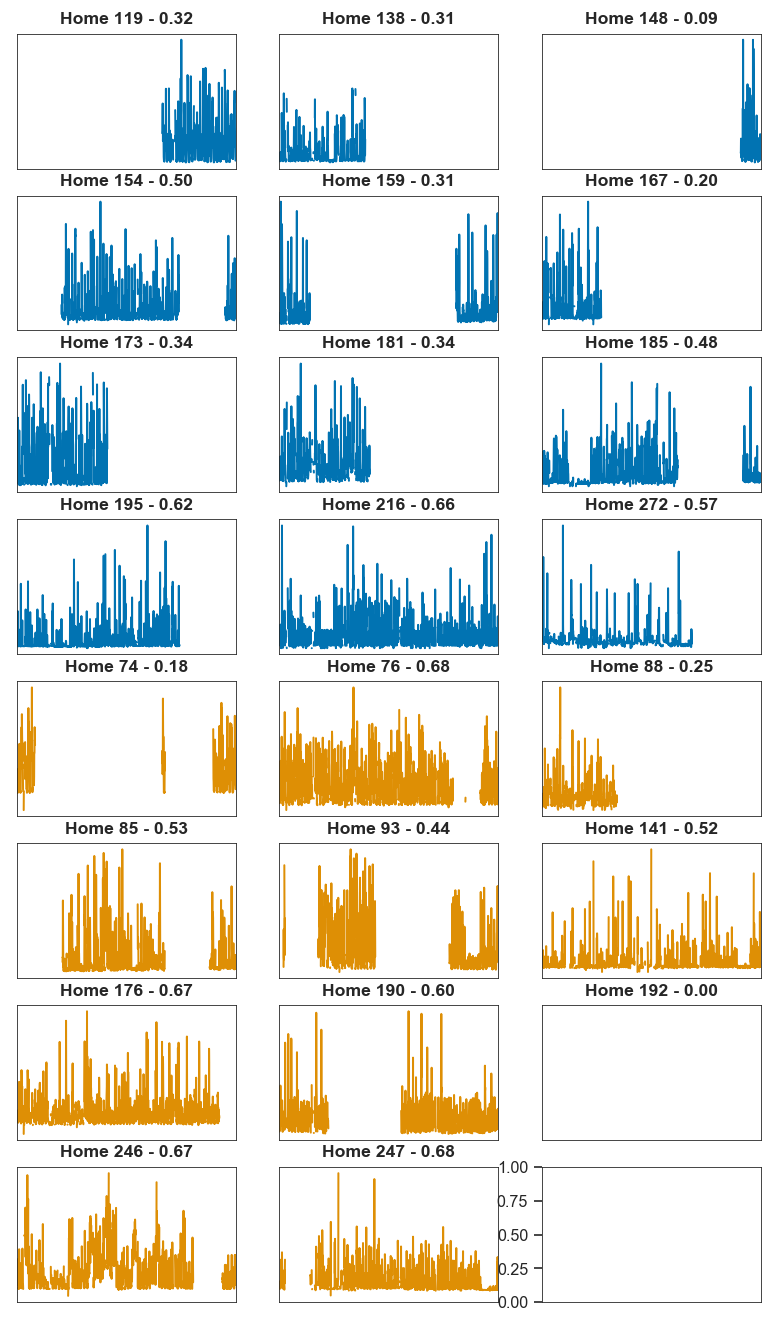

In [21]:
threshold = 0.7

idx_tmp = list(idx_drate_treatment[idx_drate_treatment < threshold].index) + \
          list(idx_drate_control[idx_drate_control < threshold].index)

df_tmp = df.loc[:,idx_tmp].resample('1h').mean()

# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(size_x, size_y), sharex=True)

i, j = 0, 0
for k in range(df_tmp.shape[1]):
    # Plot the data
    color = cmap[0]
    if k >= sum(idx_drate_treatment < threshold):
        color = cmap[1]
        
    axes[i,j].plot(df_tmp.iloc[:,k], color=color)
    
    axes[i,j].set_title('Home {} - {:.2f}'.format(df_tmp.columns[k], df.loc[:,idx_tmp[k]].notna().mean()))
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    
    axes[i,j].set_xlim((df.index.min(), df.index.max()))
    
    # Advance the subplot
    j += 1
    if j >= 3:
        i += 1
        j = 0

## P3

In [22]:
period = 'P3'

df = load_cached_data(period, full=True)

In [23]:
print('Number of homes with all missing data: {}'.format(df.isna().all(axis=0).sum()))

Number of homes with all missing data: 4


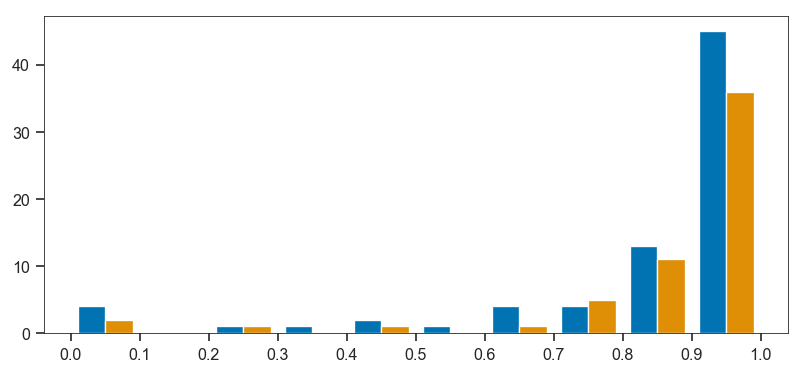

In [24]:
# Compute the mean of available data rate
idx_drate_treatment = df.loc[:,df.columns.isin(treatment_homes)].notna().mean(axis=0)
idx_drate_control = df.loc[:,df.columns.isin(control_homes)].notna().mean(axis=0)

plt.hist([idx_drate_treatment, idx_drate_control], bins=np.arange(0,1.1,0.1));

loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

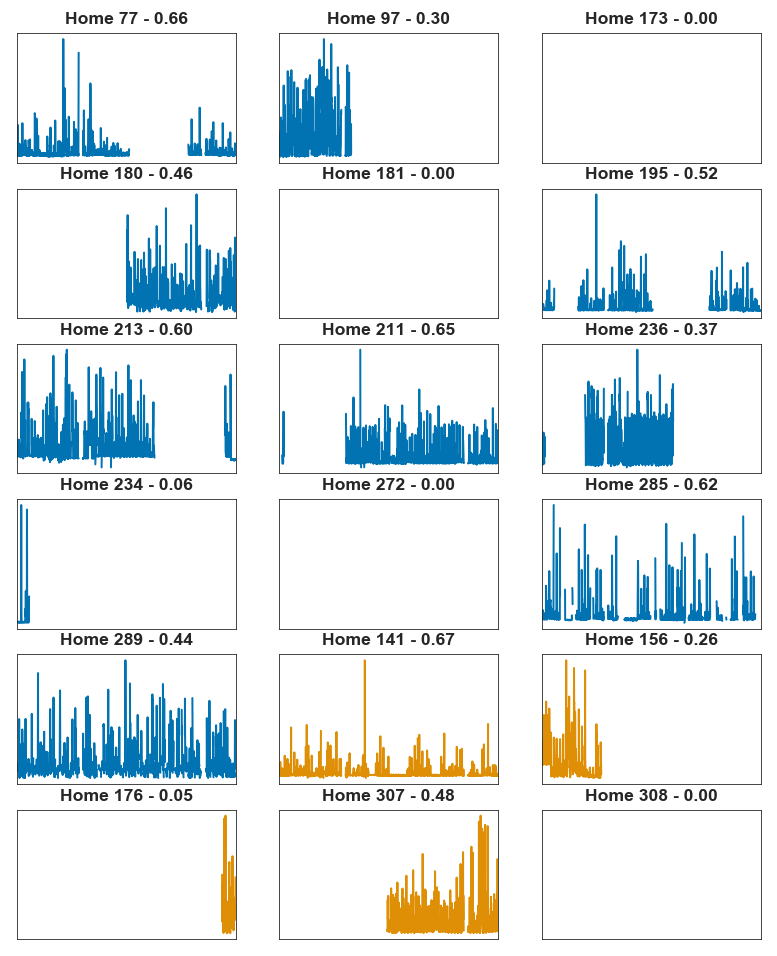

In [25]:
threshold = 0.7

idx_tmp = list(idx_drate_treatment[idx_drate_treatment < threshold].index) + \
          list(idx_drate_control[idx_drate_control < threshold].index)

df_tmp = df.loc[:,idx_tmp].resample('1h').mean()

# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


# Determine the figure size and number of subplots
nr_columns = 3
nr_rows = int(np.ceil(len(idx_tmp) / nr_columns))

size_x = double_figure[0]
size_y = int(double_figure[1] / 2 * nr_rows)


fig, axes = plt.subplots(nr_rows, nr_columns, figsize=(size_x, size_y), sharex=True)

i, j = 0, 0
for k in range(df_tmp.shape[1]):
    # Plot the data
    color = cmap[0]
    if k >= sum(idx_drate_treatment < threshold):
        color = cmap[1]
        
    axes[i,j].plot(df_tmp.iloc[:,k], color=color)
    
    axes[i,j].set_title('Home {} - {:.2f}'.format(df_tmp.columns[k], df.loc[:,idx_tmp[k]].notna().mean()))
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    
    axes[i,j].set_xlim((df.index.min(), df.index.max()))
    
    # Advance the subplot
    j += 1
    if j >= 3:
        i += 1
        j = 0